# 0. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import TomekLinks
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
import multiprocessing as mp
import pickle

# 1. EDA Pipeline

In [ ]:
def amount_descriptive_stats(data, column='transaction_type'):
    if column in ['transaction_type', 'channel']: 
        df = pd.DataFrame([])
        for trans in data['transaction_type'].unique():
            df = df.append(data[data['transaction_type']==trans]['amount'].describe().rename(trans))

        df = df.T
        return df
    else: 
        raise ValueError(f'Column: \'{column}\' not supported') 

In [ ]:
def percentages(data, plot=True):
    
    # Plot pie chart
    if plot:
        plt.figure(figsize=(5,5))
        data['flag'].value_counts().plot(kind='pie')
        plt.title('Flag pie chart')
        plt.show()
    
    #Percentages
    print(f'Percentage of {data.flag.value_counts().index[0]}: {100*data.flag.value_counts()[0]/sum(data.flag.value_counts())}')
    print(f'Percentage of {data.flag.value_counts().index[1]}: {100*data.flag.value_counts()[1]/sum(data.flag.value_counts())}')

In [ ]:
def exploratory_visualization(data, column='transaction_type', plt_type='bar'):
    
    if column in ['transaction_type', 'channel']: 
        if plt_type=='bar':
            plt.figure(figsize=(15,15))
            i=0
            for trans in data[column].unique():
                i+=1
                ax = plt.subplot(5, 5, i)
                plt.boxplot(data[data[column]==trans]['amount'])
                plt.title(trans)
            plt.tight_layout(h_pad=1 , w_pad=1.5)
            #plt.suptitle('Boxplots of amount per transaction type',  fontsize=25)
            plt.show()
        elif plt_type=='hist':
            plt.figure(figsize=(15,15))
            i=0
            for trans in data[column].unique():
                i+=1
                ax = plt.subplot(5, 5, i)
                plt.hist(data[data[column]==trans]['amount'])
                plt.title(trans)
            plt.tight_layout(h_pad=1 , w_pad=1.5)
            #plt.suptitle('Boxplots of amount per transaction type',  fontsize=25)
            plt.show()
        else:
            raise ValueError(f'Plot type: \'{plt_type}\' not supported')       
    else: 
        raise ValueError(f'Column: \'{column}\' not supported') 

In [ ]:
def transactions_type(data, plot=True):
    if plot:
        data['channel'].value_counts().plot(kind='barh')
        plt.title('Number of transtactions per type')
        plt.show()
        
    return transactions['channel'].value_counts()

# Read data

In [ ]:
transactions = [pd.read_csv('sim4.csv', delimiter=';'), pd.read_csv('sim5.csv', delimiter=';'),pd.read_csv('sim1.csv', delimiter=',')]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Explore data

In [ ]:
transactions.info()

AttributeError: ignored

In [ ]:
transactions.head()

AttributeError: ignored

In [ ]:
len(transactions['channel'].unique())

In [ ]:
transactions.tail()

In [ ]:
transactions.columns

In [ ]:
transactions.shape

In [ ]:
amount_descriptive_stats(transactions)

In [ ]:
percentages(transactions)

In [ ]:
transactions[transactions['transaction_type']=='bribe']['amount']

In [ ]:
exploratory_visualization(transactions, column='channel' ,plt_type='hist')

In [ ]:
transactions_type(transactions, plot=True)

# One hot encoding

In [ ]:
def float_to_string(x):
    if type(x) == float:
        return str(x)
    else:
        return x

In [ ]:
transactions[2]['transaction_type'] = transactions[2]['transaction_type'].apply(lambda x: float_to_string(x))

In [ ]:
transactions_one_hot = [pd.get_dummies(data, columns=['channel', 'transaction_type']) for data in transactions]

In [ ]:
transactions[1].head()

,account_from,account_to,sender,receiver,amount,channel,currency,date,flag,location,transaction_type,transaction_id
0,Account 617,Account 618,Fraudulent_businesses 8,Fraudulent_businesses 9,999.75,LINK,GBP,1/01/2021 9:03,transaction,UK,0.1,198163
1,Account 617,Account 618,Fraudulent_businesses 8,Fraudulent_businesses 9,618.67,FPS,GBP,1/01/2021 9:03,transaction,UK,0.1,198164
2,Account 617,Account 618,Fraudulent_businesses 8,Fraudulent_businesses 9,95.13,FPS,GBP,1/01/2021 9:03,transaction,UK,0.1,198165
3,Account 617,Account 618,Fraudulent_businesses 8,Fraudulent_businesses 9,808.09,LINK,GBP,1/01/2021 9:03,transaction,UK,0.1,198166
4,Account 617,Account 618,Fraudulent_businesses 8,Fraudulent_businesses 9,442.39,LINK,GBP,1/01/2021 9:03,transaction,UK,0.1,198167


In [ ]:
transactions_one_hot[0].head()

,account_from,account_to,sender,receiver,amount,currency,date,flag,location,transaction_id,channel_Bacs,channel_C&CCC,channel_CASH,channel_CHAPS,channel_FPS,channel_LINK,channel_Paym,transaction_type_0.1,transaction_type_0.2,transaction_type_1.1,transaction_type_1.2,transaction_type_2.2,transaction_type_3.1,transaction_type_3.2,transaction_type_3.3,transaction_type_4.1,transaction_type_4.2,transaction_type_5,transaction_type_bribe,transaction_type_cashout,transaction_type_kickback payment,transaction_type_pay false service,transaction_type_travel expenses payment
0,Account 508,Account 584,Fraudulent_businesses 14,Fraudulent_individuals 21,20000.00,GBP,1/01/2021 9:03,fraud,UK,155401,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,Account 511,Account 585,Businesses 17,Fraudulent_individuals 18,20000.00,GBP,1/01/2021 9:03,fraud,UK,155402,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,Account 578,Account 562,Individuals 64,Individuals 48,36.80,GBP,1/01/2021 9:03,transaction,UK,155403,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Account 578,Account 562,Individuals 64,Individuals 48,48.66,GBP,1/01/2021 9:03,transaction,UK,155404,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Account 578,Account 562,Individuals 64,Individuals 48,100.31,GBP,1/01/2021 9:03,transaction,UK,155405,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
transactions[0].shape, transactions_one_hot[0].shape

((42762, 12), (42762, 33))

# Correlation

In [ ]:
transactions_one_hot.corr()

AttributeError: ignored

In [ ]:
transactions_one_hot.columns

In [ ]:
transactions.channel.unique()

In [ ]:
# Veamos la correlacion con un mapa de calor
corr_data = transactions_one_hot[['amount', 'channel_Bacs', 'channel_C&CCC', 'channel_CASH', 'channel_CHAPS',
                                 'channel_FPS', 'channel_LINK', 'channel_Paym']]
plt.figure(figsize=(35, 30))
heatmap = sns.heatmap(corr_data.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12);

In [ ]:
corr_data = transactions_one_hot[['transaction_type_0.1', 'transaction_type_0.2', 'transaction_type_1.1', 
                      'transaction_type_1.2', 'transaction_type_2.2', 'transaction_type_3.1', 
                      'transaction_type_3.3', 'transaction_type_4.2', 'transaction_type_5.0', 
                      'transaction_type_0.1', 'transaction_type_0.2', 'transaction_type_1.1', 
                      'transaction_type_1.2', 'transaction_type_2.2', 'transaction_type_3.1', 
                      'transaction_type_3.2', 'transaction_type_3.3', 'transaction_type_4.1', 
                      'transaction_type_4.2', 'transaction_type_5.0', 'transaction_type_bribe', 
                      'transaction_type_cashout', 'transaction_type_kickback payment', 
                      'transaction_type_pay false service', 'transaction_type_travel expenses payment']]

plt.figure(figsize=(35, 30))
heatmap = sns.heatmap(corr_data.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12);

# Data preparation

In [ ]:
from sklearn import preprocessing

Transactions=[
              data.drop(columns=['account_from', 'account_to', 'currency', 'location','transaction_id','sender','receiver','date']) 
              for data in transactions_one_hot
              ]
Transactions=[data[data['flag'].notna()] for data in Transactions]

for data in Transactions:
  le = preprocessing.LabelEncoder()
  le.fit(data.flag)
  data['Flagged'] = le.transform(data.flag)

Transactions = [data.drop(columns=['flag']) for data in Transactions]

X=[data.iloc[:,0:-1] for data in Transactions]
y=[data.iloc[:,-1] for data in Transactions]

In [ ]:
for label in y:
  print(label.value_counts())
  print('\n')

1    41977
0      785
Name: Flagged, dtype: int64


1    25582
0      510
Name: Flagged, dtype: int64


1    142776
0       440
Name: Flagged, dtype: int64




# Split train-test

In [ ]:
def traintest(X, y, num=0.3):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num, random_state=42)
  return X_train, y_train, X_test, y_test

# Prediction

In [ ]:
def prediction(model, X_test, y_test):
  y_fit=model.predict(X_test)
  report=classification_report(y_test,y_fit)
  return y_fit, report

# Classification Methods

## Suport Vector Machine

In [ ]:
def svm(X_train, y_train, string='rbf', num=1E8):
  model = SVC(kernel=string, C=num)
  model.fit(X_train, y_train)
  return model

## Random forest classification

In [ ]:
def rforest(X_train, y_train):
  tree = RandomForestClassifier().fit(X_train, y_train)
  return tree

# Balance Methods

## Undersampling

### Random Undersampling

In [ ]:
def rundersampling(X, y, threshold=0.5):
  X=X.to_numpy()
  y=y.to_numpy()
  undersample = RandomUnderSampler(sampling_strategy=threshold)
  X_under , y_under=undersample.fit_resample(X, y)
  print("RANDOM UNDERSAMPLING")
  print("Original balance")
  print(Counter(y))
  print("Undersampled balance")
  print(Counter(y_under))
  print("\n")
  return X_under, y_under

### Near_Miss_1

In [ ]:
def nearm1(X, y, n_neighbors=3):
  X=X.to_numpy()
  y=y.to_numpy()
  undersample = NearMiss(version=1, n_neighbors=3)
  X_under , y_under=undersample.fit_resample(X, y)
  print("NEAR MISS 1 UNDERSAMPLING")
  print("Original balance")
  print(Counter(y))
  print("Undersampled balance")
  print(Counter(y_under))
  print("\n")
  return X_under, y_under

### Tomek Links

In [ ]:
def tomeklinks(X, y):
  X=X.to_numpy()
  y=y.to_numpy()
  undersample = TomekLinks()
  X_under , y_under=undersample.fit_resample(X, y)
  print("TOMEK LINKS UNDERSAMPLING")
  print("Original balance")
  print(Counter(y))
  print("Undersampled balance")
  print(Counter(y_under))
  print("\n")
  return X_under, y_under


## Oversampling

### Random Oversampling

In [ ]:
def roversampling(X, y, threshold=0.3):
  X=X.to_numpy()
  y=y.to_numpy()
  oversample = RandomOverSampler(sampling_strategy=threshold)
  X_over , y_over=oversample.fit_resample(X, y)
  print("RANDOM OVERSAMPLING")
  print("Original balance")
  print(Counter(y))
  print("Oversampled balance")
  print(Counter(y_over))
  print("\n")
  return X_over, y_over

# Balance the data

In [ ]:
def balancedata(methods, X, y):
  new_data = []
  for method in methods:
    X_new, y_new = method(X,y)
    new_data.append([X_new, y_new])
  return new_data

In [ ]:
methods = [rundersampling, nearm1, roversampling]
num_methods = len(methods) + 1
methods_names= ['RAW','RANDOM UNDERSAMPLING', 'NEAR MISS 1 UNDERSAMPLING', 'RANDOM OVERSAMPLING']
balanced = []
count = 1
'''
for i,j in zip(X,y):
  print("######### DATA FRAME {} #########".format(count))
  b = balancedata(methods, i, j)
  balanced.append(b)
  count +=1
'''
balanced = balancedata(methods, X[2], y[2])

RANDOM UNDERSAMPLING
Original balance
Counter({1: 142776, 0: 440})
Undersampled balance
Counter({1: 880, 0: 440})


NEAR MISS 1 UNDERSAMPLING
Original balance
Counter({1: 142776, 0: 440})
Undersampled balance
Counter({0: 440, 1: 440})


RANDOM OVERSAMPLING
Original balance
Counter({1: 142776, 0: 440})
Oversampled balance
Counter({1: 142776, 0: 42832})




## Para mandar al otro equipo

In [ ]:
a = pd.DataFrame(balanced[0][0])
b = pd.DataFrame(balanced[0][1])

data_undersampling = pd.concat([a,b], axis=1, ignore_index=True)

a = pd.DataFrame(balanced[2][0])
b = pd.DataFrame(balanced[2][1])

data_oversampling = pd.concat([a,b], axis=1, ignore_index=True)

data_names = ['X{}'.format(i) for i in range(24)]
data_names.append('y')

data_undersampling.columns = data_names
data_oversampling.columns = data_names

data_undersampling.to_csv('Datos_undersampling.csv')
data_undersampling.to_csv('Datos_oversampling.csv')


# Carry on classification on balanced data

## Load premodified models


In [ ]:
# LOAD THE MODELS
svm_models = []
for i in range(num_methods):
  filename = "svm_model with Sim1 as training{}.sav".format(i)
  loaded_model = pickle.load(open(filename, 'rb'))
  svm_models.append(loaded_model)

# Split data


In [ ]:
#balanced_data = [traintest(X[0],y[0])]
balanced_data = []
for data in balanced:
  #X_train, y_train, X_test, y_test = traintest(data[0],data[1])
  X_train, y_train, X_test, y_test = data[0], data[1], X[0], y[0]
  balanced_data.append([X_train, y_train, X_test, y_test])

## Support vector machine

In [ ]:
svm_models = [svm(X[2], y[2])]
for data in balanced_data:
  svm_models.append(svm(data[0],data[1]))

In [ ]:
predictions=[]
for i in range(len(svm_models)):
  predictions.append(prediction(svm_models[i],balanced_data[0][2],balanced_data[0][3]))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- transaction_type_5
Feature names seen at fit time, yet now missing:
- transaction_type_5.0

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
for pred,name in zip(predictions,methods_names):
  print(name)
  print(pred[1])
  print('\n')

## Save Models


In [ ]:
# SAVE THE MODELS
for i in range(len(svm_models)):
  filename = "svm_model with Sim1 as training{}.sav".format(i)
  pickle.dump(svm_models[i], open(filename, 'wb'))

#Random Forest


In [ ]:
ran_models = [rforest(X[2], y[2])]
for data in balanced_data:
  ran_models.append(rforest(data[0],data[1]))

In [ ]:
predictions1=[]
for i in range(len(ran_models)):
  predictions1.append(prediction(ran_models[i],balanced_data[0][2],balanced_data[0][3]))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- transaction_type_5
Feature names seen at fit time, yet now missing:
- transaction_type_5.0

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {se

In [ ]:
for pred,name in zip(predictions1,methods_names):
  print(name)
  print(pred[1])
  print('\n')

RAW
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       785
           1       1.00      1.00      1.00     41977

    accuracy                           1.00     42762
   macro avg       1.00      1.00      1.00     42762
weighted avg       1.00      1.00      1.00     42762



RANDOM UNDERSAMPLING
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       785
           1       1.00      1.00      1.00     41977

    accuracy                           1.00     42762
   macro avg       0.99      1.00      0.99     42762
weighted avg       1.00      1.00      1.00     42762



NEAR MISS 1 UNDERSAMPLING
              precision    recall  f1-score   support

           0       0.04      1.00      0.07       785
           1       1.00      0.50      0.66     41977

    accuracy                           0.50     42762
   macro avg       0.52      0.75      0.37     42762
weighted avg       

#Cross validation


In [ ]:
clf = SVC(kernel='rbf', C=1E8, random_state=42)

scores = cross_val_score(clf, X, y, cv=5,n_jobs=-1)

In [ ]:
scores

In [ ]:
X_under=balanced[0][0]
y_under=balanced[0][1]

In [ ]:
scores2=cross_val_score(clf, X_under, y_under, cv=5)

In [ ]:
scores2

In [ ]:
tlf=RandomForestClassifier().fit(X_train, y_train)
scores3 = cross_val_score(tlf, X, y, cv=5)

In [ ]:
scores3

# Confusion Matrix

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- transaction_type_5
Feature names seen at fit time, yet now missing:
- transaction_type_5.0

  warnings.warn(message, FutureWarning)


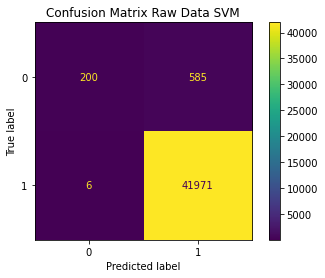

In [ ]:
y_true_raw=y[0]
y_pred_raw=predictions[0][0]

plot_confusion_matrix(svm_models[0],balanced_data[0][2], y_true_raw) 
plt.title("Confusion Matrix Raw Data SVM")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


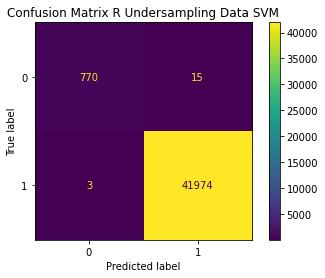

In [ ]:
y_true_raw=y[0]
y_pred_raw=predictions[0][0]

plot_confusion_matrix(svm_models[1],balanced_data[0][2], y_true_raw) 
plt.title("Confusion Matrix R Undersampling Data SVM")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


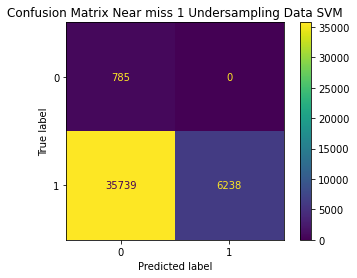

In [ ]:
y_true_raw=y[0]
y_pred_raw=predictions[0][0]

C=confusion_matrix(y_true_raw, y_pred_raw)
plot_confusion_matrix(svm_models[2],balanced_data[0][2], y_true_raw) 
plt.title("Confusion Matrix Near miss 1 Undersampling Data SVM")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


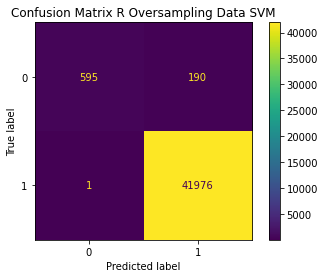

In [ ]:
y_true_raw=y[0]
y_pred_raw=predictions[0][0]

C=confusion_matrix(y_true_raw, y_pred_raw)
plot_confusion_matrix(svm_models[3],balanced_data[0][2], y_true_raw) 
plt.title("Confusion Matrix R Oversampling Data SVM")
plt.show()

In [ ]:
C2 / C2.astype(np.float).sum(axis=1)

# Roc-AUC


In [ ]:
Roc_Raw=roc_auc_score(y[0], svm_models[0].decision_function(X[0]))
Roc_Under=roc_auc_score(y[0], svm_models[1].decision_function(X[0]))
Roc_Near=roc_auc_score(y[0], svm_models[2].decision_function(X[0]))
Roc_Over=roc_auc_score(y[0], svm_models[3].decision_function(X[0]))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- transaction_type_5
Feature names seen at fit time, yet now missing:
- transaction_type_5.0

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
print("Roc-AUC SVM with Raw:")
print(Roc_Raw)
print("\n"+"Roc-AUC SVM with RUndesample:")
print(Roc_Under)
print("\n"+"Roc-AUC SVM with Near-Miss 1 Undersample:")
print(Roc_Near)
print("\n"+"Roc-AUC SVM with ROversample:")
print(Roc_Over)

Roc-AUC SVM with Raw:
0.9799661598124176

Roc-AUC SVM with RUndesample:
0.9950804421408205

Roc-AUC SVM with Near-Miss 1 Undersample:
0.49143683324307563

Roc-AUC SVM with ROversample:
0.9999634315971334


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- transaction_type_5
Feature names seen at fit time, yet now missing:
- transaction_type_5.0

  warnings.warn(message, FutureWarning)


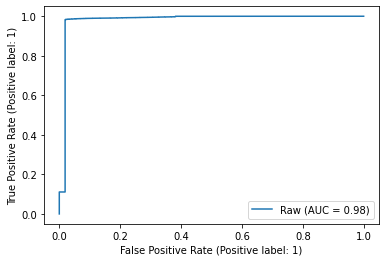

In [ ]:
metrics.plot_roc_curve(svm_models[0], X[0], y[0],name="Raw")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


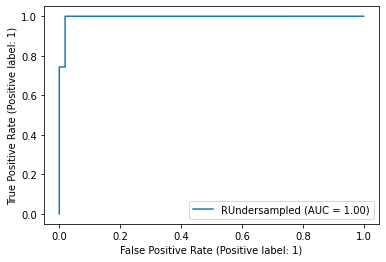

In [ ]:
metrics.plot_roc_curve(svm_models[1], X[0], y[0],name="RUndersampled")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


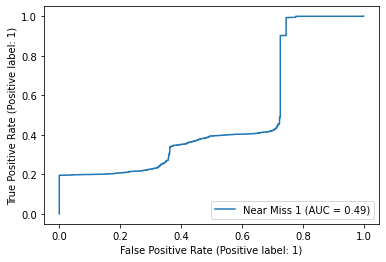

In [ ]:
metrics.plot_roc_curve(svm_models[2], X[0], y[0],name="Near Miss 1")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


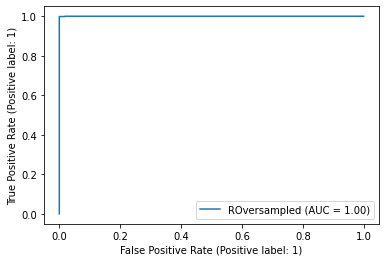

In [ ]:
metrics.plot_roc_curve(svm_models[3], X[0], y[0],name="ROversampled")

In [ ]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, "o-")
    axes[2].fill_between(
        fit_times_mean,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [ ]:
model = SVC(kernel='rbf', C=1E8)
plot_learning_curve(model,"Curva de aprendizaje SVM RAW",X[0],y[0])

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

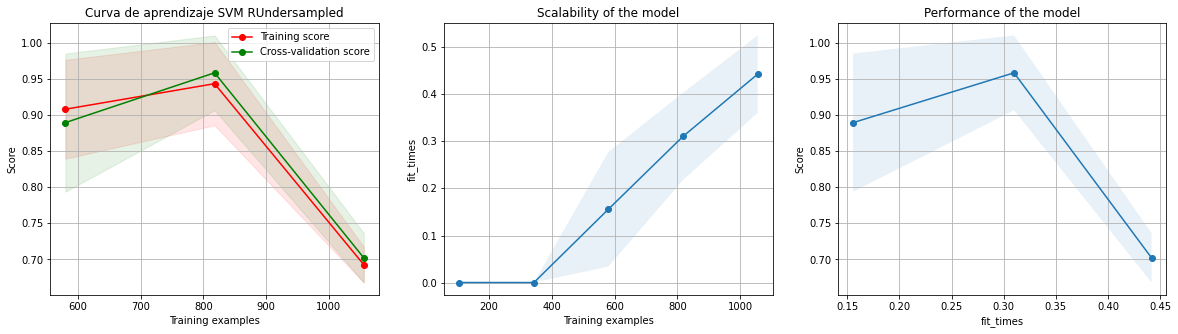

In [ ]:
model = SVC(kernel='rbf', C=1E8)
plot_learning_curve(model,"Curva de aprendizaje SVM RUndersampled",balanced_data[0][0],balanced_data[0][1])

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

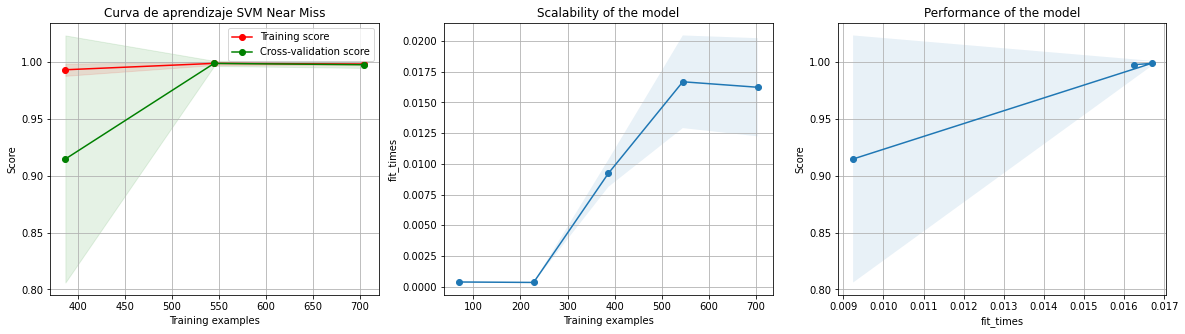

In [ ]:
plot_learning_curve(model,"Curva de aprendizaje SVM Near Miss",balanced_data[1][0],balanced_data[1][1])

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

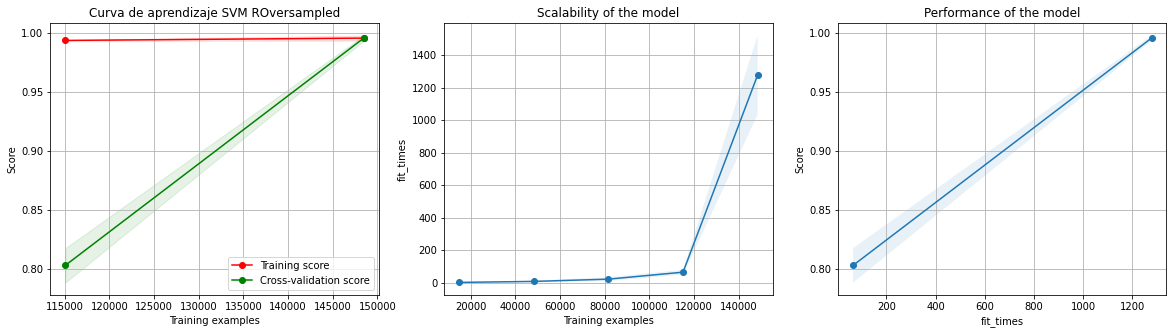

In [ ]:
plot_learning_curve(model,"Curva de aprendizaje SVM ROversampled",balanced_data[2][0],balanced_data[2][1])